# Examine Delight output for desc dc2

- author : Sylvie Dagoret-Campagne
- date : March 20th 2021
- affiliation : IJCLab/IN2P3/CNRS

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [45]:
import sys
from mpi4py import MPI
import numpy as np
from scipy.interpolate import interp1d
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel
import scipy.stats
import matplotlib.pyplot as plt
import emcee
import corner

# Create a logger object.
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s %(name)s[%(process)d] %(levelname)s %(message)s')

comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()

In [46]:
from pkg_resources import resource_filename

In [47]:
!ls tmp

delight_data	       parametersTest_15.cfg  parametersTest_21.cfg
parametersTest.cfg     parametersTest_16.cfg  parametersTest_3.cfg
parametersTest_1.cfg   parametersTest_17.cfg  parametersTest_4.cfg
parametersTest_10.cfg  parametersTest_18.cfg  parametersTest_5.cfg
parametersTest_11.cfg  parametersTest_19.cfg  parametersTest_6.cfg
parametersTest_12.cfg  parametersTest_1_.cfg  parametersTest_7.cfg
parametersTest_13.cfg  parametersTest_2.cfg   parametersTest_8.cfg
parametersTest_14.cfg  parametersTest_20.cfg  parametersTest_9.cfg


# Configuration

### DESC Delight data

In [48]:
configdatafilename="tmp/parametersTest_15.cfg"

In [49]:
paramsdata = parseParamFile(configdatafilename, verbose=True)

2021-03-20 19:02:32,995 ipykernel_launcher.py, delight.io[157] WARNING Input parameter file:tmp/parametersTest_15.cfg
2021-03-20 19:02:32,998 ipykernel_launcher.py, delight.io[157] WARNING Parameters read:


>  rootDir              ./
>  bands_directory      /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/FILTERS
>  bandNames            lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
>  numCoefs             15
>  bands_verbose        True
>  bands_debug          True
>  bands_makeplots      False
>  templates_directory  /home/ubuntu/.local/lib/python3.8/site-packages/delight/../data/CWW_SEDs
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  templates_verbose    False
>  templates_debug      False
>  training_numChunks   1
>  training_paramFile   ./tmp/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmp/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand lsst_i
>  training_bandOrder   lsst_u lsst_u_var lsst_g 

# Analyse

In [50]:
params=paramsdata

In [51]:
DL = approx_DL()
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)

In [52]:

bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')


## Analyze the outputs

In [53]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

479 150 394 116 120 192 1 511 432 468 210 88 101 84 402 295 424 65 388 249 

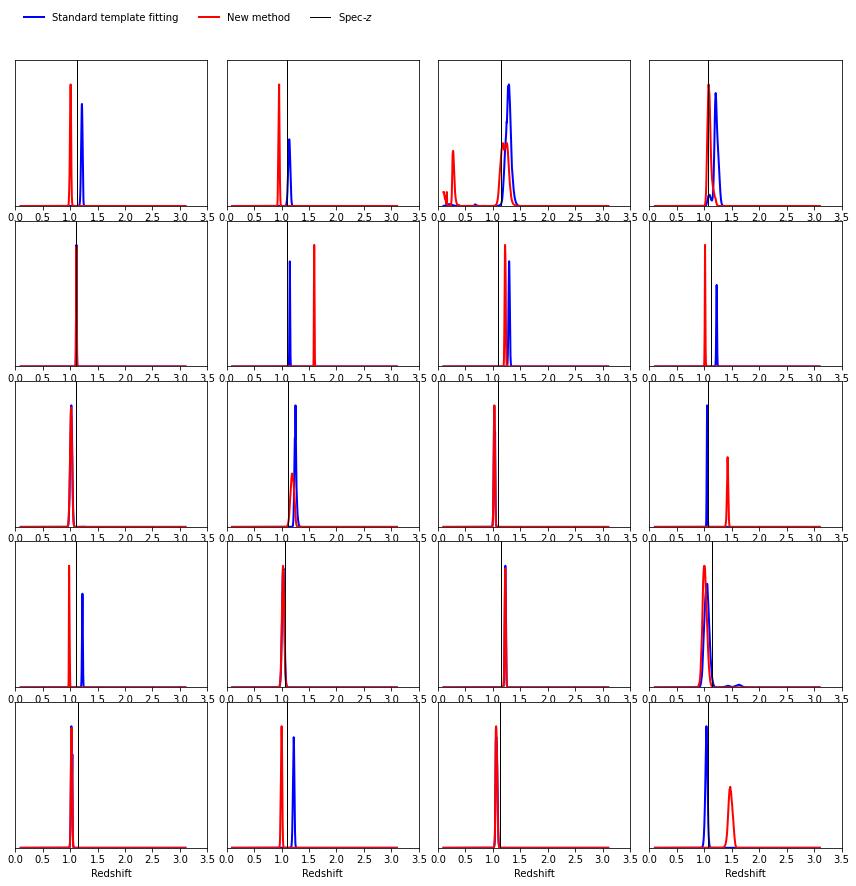

In [54]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(12, 12), sharex=False, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw,color='b' ,label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, color="r",label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 3.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


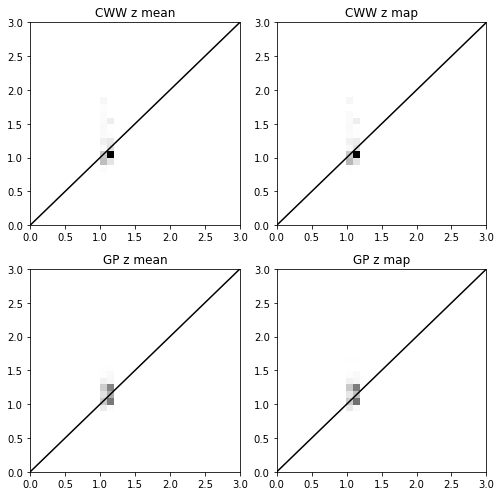

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
zmax = 3
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
fig.tight_layout()

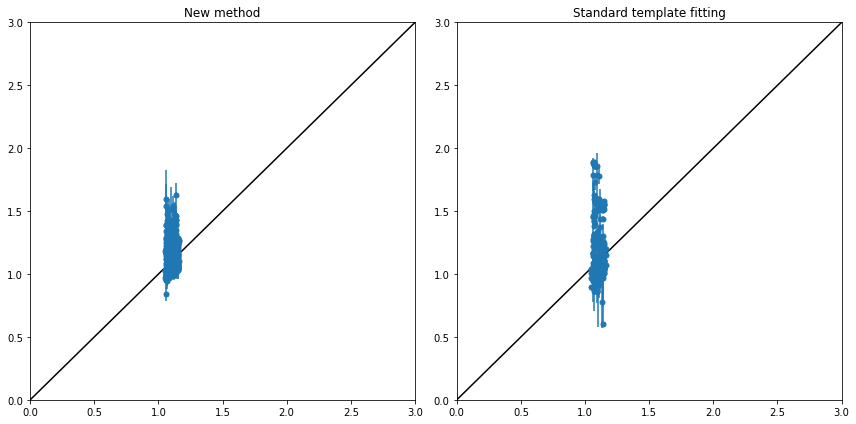

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

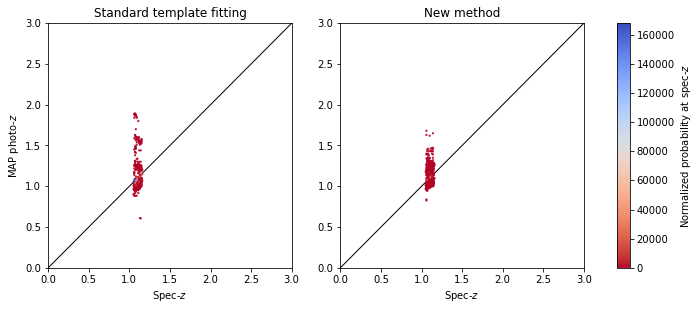

In [57]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.